# init

In [1]:
# math stuff
import numpy as np
# visualization
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import distance
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline
# sliders
from ipywidgets import interactive

# for matrix import and display
import pandas as pd
from IPython.display import display_html 

# to be able to use python files
import sys 
sys.path.append('pyfiles/')
import classes as cl
# This reloads external modules every time a cell is run
# so we don't have to reboot kernel every time we modify classes.py
%load_ext autoreload
%autoreload 2
import csv #for loading function

# input shape

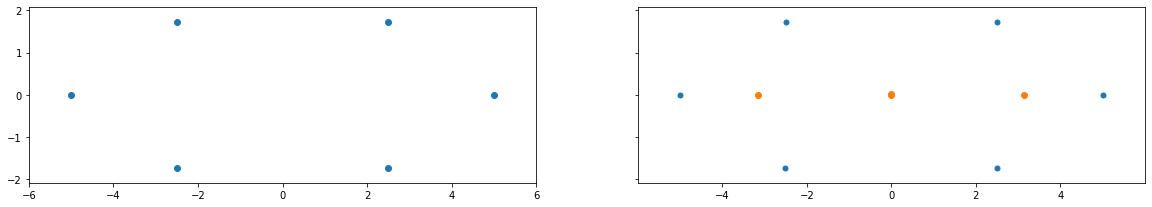

In [2]:
points = cl.ellipse_example(numpts = 6)

# turn points into simplices, add connecting edges, order under dist sq

init  number of verts is 6, and number of edges is 0 
complexx  number of verts is 6, and number of edges is 6 
ordered  number of verts is 0, and number of edges is 0
[5.84, 0.62, 28.62, 61.84, 35.65, 7.55]


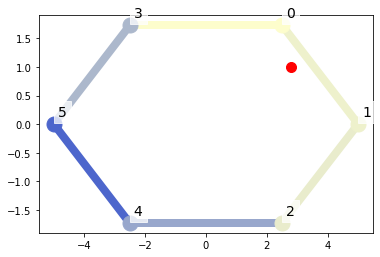

init  number of verts is 6, and number of edges is 0 
complexx  number of verts is 6, and number of edges is 6 
ordered  number of verts is 6, and number of edges is 6


In [3]:
init_complex = cl.complex()
init_complex.init_verts(points)

# I don't remember if the deepcopy were to learn about 
# python linking things together, or if it served a later purpose
complexx = deepcopy(init_complex)
complexx.init_edges()
# complexx.plot()

# I don't remember why we need to deepcopy again. do we really?
# I also don't remember why it works to deepcopy an empty cplx
# is it getting the data from complexx, or initcomplex??
#orderedcplx = deepcopy(cl.complex())
orderedcplx = cl.complex()
print("init ", init_complex, "\ncomplexx ", complexx, "\nordered ", orderedcplx)


# the key point is the one we will take the squared dist from
orderedcplx.key_point = (2.8,1)
distlist = orderedcplx.find_sq_dist(init_complex)

# PERMUTE indices
orderedcplx.sort_inds(distlist)
# orderedcplx.print_inds()
# now, orderedcplx has a correct orderedindex for every vert
# edges still need to be indexed based on this ordering

# TODO: DECIDE ON RULE FOR THE BOUNDARY: INITIAL INPUT OR ORDERED
# we want to put them into the matrix in order but we'll change it later

orderedcplx.sort_edges()
orderedcplx.plot()

print("init ", init_complex, "\ncomplexx ", complexx, "\nordered ", orderedcplx)

# print([v.index for v in orderedcplx.vertlist])

## Next we want to build the persistence matrix.
this gives a total order on verts and edges, first by function value, and then by dimension, and then by initial index

In [4]:
all_simplices = orderedcplx.vertlist + orderedcplx.edgelist
simplex_key = lambda simplex: (simplex.orderedindex, len(simplex.boundary), simplex.index)
all_simplices.sort(key=simplex_key)

for i in range(len(all_simplices)):
    all_simplices[i].columnvalue = i + 1

In [5]:
print(orderedcplx.vertlist)
print(orderedcplx.edgelist)

[
simplex ind 0, dim 0, bd [-1], ord ind 1, col val 2, 
simplex ind 1, dim 0, bd [-1], ord ind 0, col val 1, 
simplex ind 2, dim 0, bd [-1], ord ind 3, col val 6, 
simplex ind 3, dim 0, bd [-1], ord ind 5, col val 10, 
simplex ind 4, dim 0, bd [-1], ord ind 4, col val 8, 
simplex ind 5, dim 0, bd [-1], ord ind 2, col val 4]
[
simplex ind 0, dim 1, bd [0, 1], ord ind 1, col val 3, 
simplex ind 1, dim 1, bd [1, 2], ord ind 3, col val 7, 
simplex ind 2, dim 1, bd [2, 3], ord ind 5, col val 11, 
simplex ind 3, dim 1, bd [3, 4], ord ind 5, col val 12, 
simplex ind 4, dim 1, bd [4, 5], ord ind 4, col val 9, 
simplex ind 5, dim 1, bd [5, 0], ord ind 2, col val 5]


## build the boundary matrix and reduce it

NOTE: Matrix is for reduced homology, so it starts with the empty set in col 0.
also to note: we use one big matrix for edges and verts, so they are intermingled.

Matrix is a square matrix, with length nedges + nverts + 1 (because of empty simplex for reduced homology)
NOTE: WE DON'T ALLOW FOR TRIANGLES YET BUT EVENTUALLY SHOULD

simplices in filtration order across top and same order going down
child is going down and parent is across 
if child i in parent j, (i,j) row,column gets a 1
for all vert parents: they all get a 1 for empty set and 0 else

In [6]:
mat = cl.bdmatrix()
mat.make_matrix(orderedcplx)

reduced = mat.reduce(display = False)
mat.redmatrix = reduced

# this adds in a column for reduced homology
mat.add_dummy_col()
# do smart thing to get rid of all_simplices
# maybe keep a list on the complex class?
mat.find_lows_zeros(all_simplices)

    
print("Zero Columns:")
for key, value in mat.zerocolumns.items():
    print(key, ":", value)
print("\nLowest Ones:")
for key, value in mat.lowestones.items():
    print(key, ":", value)
    

betti_dummy, betti_zero, betti_one = mat.find_bettis()

print("dummy: ", betti_dummy, "\nzero: ", betti_zero, "\none:" ,betti_one)

columns:  13  rows:  13
Zero Columns:
col : [0, 2, 4, 6, 8, 10, 12]
dim : [-1, 0, 0, 0, 0, 0, 1]
col_index : [-1, 0, 5, 2, 4, 3, 3]

Lowest Ones:
col : [1, 3, 5, 7, 9, 11]
row : [0, 2, 4, 6, 8, 10]
dim : [-1, 0, 0, 0, 0, 0]
col_index : [1, 0, 5, 1, 4, 2]
row_index : [-1, 0, 5, 2, 4, 3]
dummy:  0 
zero:  0 
one: 1


# misc

note

 if column is repr as set of indices, max yields lowest one
 max can (maybe) be re-keyed to return max wrt ie radius instead of index
 max(column, key=...), key as lambda funcion like for enumerate

 consider redoing matrices? 
 
 note from Teresa: we can separate the matrices into one each for verts, edges, triangles, 
... not sure if this is better in practice

In [7]:
[i*3 for i in range(5)]

[0, 3, 6, 9, 12]

In [8]:
{i**2 for i in range(-5,6)}

{0, 1, 4, 9, 16, 25}